In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
np.random.seed(10)

# Datasets

In [ ]:
df_heart = pd.read_csv("datasets\heart.csv")
print(df_heart.shape)
df_heart.head()

In [ ]:
df_orbit = pd.read_csv("datasets\classast - pha.csv")
print(df_orbit.shape)
df_orbit.head()

# Naive Bayes

In [ ]:
def cross_validation_NB(df, noise, nombreClase, training):
    clases = df[nombreClase]
    dfL = df.drop(nombreClase, axis=1)
    kfolder = KFold(n_splits=10, shuffle=False)
    fold_index = 1
    totalRisk = 0

    for train_index, test_index in kfolder.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        theta, phi = training(train_df, noise)
        risk = 0
        riskList = test_df.apply(testingNB, args= (theta, phi, clases, dfL.columns[0:-1], nombreClase), axis=1)
        risk = riskList.sum()
        totalRisk += risk
        fold_index += 1
    return totalRisk/len(df)

def testingNB(t, theta, phi, clases, cols, clase):
    y = t[clase]
    y_hat = -1
    maxVer = -99999999
    maxProb = -1
    risk = 0
    # por cada clase
    for k in clases:
        log_verosim = np.log(theta[k])
        # phi de cada atributo
        for _, i in enumerate(cols):
            phi_ij = phi[i][k][t[i]]
            if phi_ij != 0:
                log_verosim += np.log(phi_ij)
        # escoger k más probable
        if log_verosim > maxVer:
            maxVer = log_verosim
            # maxProb = prob_k
            y_hat = k
    if y_hat!=y:
        risk = 1
    return risk

Enfermedad cardíaca

In [ ]:
hnb_df = pd.read_csv("datasets\heart.csv")

def trainingHeart(train, noiseProb):

    # ruido
    train.heartdisease = train.heartdisease.map(lambda i: abs(i - 1) if np.random.random() < noiseProb else i)

    theta = []
    phi = {
        'age': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
        'sex': [[0, 0], [0, 0]],
        'chestpaintype': [{'TA': 0, "ATA": 0, "NAP": 0, "ASY":0},
                          {'TA': 0, "ATA": 0, "NAP": 0, "ASY":0}],
        'restingbp': [[0, 0, 0, 0], [0, 0, 0, 0]],
        'cholesterol': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
        'fastingbs': [[0, 0], [0, 0]],
        'restingecg': [{"Normal": 0, "ST": 0, "LVH": 0},
                      {"Normal": 0, "ST": 0, "LVH": 0}],
        'maxhr': [[0, 0, 0, 0], [0, 0, 0, 0]],
        'exerciseangina': [[0, 0], [0, 0]],
        'oldpeak': [[0, 0, 0, 0], [0, 0, 0, 0]],
        'st_slope': [{"Up": 0, "Flat": 0, "Down": 0},
                    {"Up": 0, "Flat": 0, "Down": 0}]
    }

    n = len(train)
    B = [len(train[i].unique()) for i in train.columns[0:-1]]

    # por cada clase (0,1)
    K = train.heartdisease.unique()
    for k in K:
        x_l = train[train.heartdisease == k]
        n_k = len(x_l)

        theta_k = (n_k + 1) / (n + len(K))
        theta.append(theta_k)

        # por cada atributo
        for index_i, i in enumerate(x_l.columns[0:-1]):

            js = x_l[i].value_counts() # cantidad de ocurrencias de cada valor
            for index_j, j in enumerate(js.index.tolist()):
                n_j = js.tolist()[index_j]
                phi[i][k][j] = (n_j + 1)/(n_k + B[index_i])

    return theta, phi


hnb_df.columns = map(str.lower, hnb_df.columns)
hnb_df.sex = hnb_df.sex.map(lambda x: 0 if x == 'M' else 1) #0=M 1=F
hnb_df.exerciseangina = hnb_df.exerciseangina.map(lambda x: 1 if x == 'Y' else 0) #0=N 1=Y
# df = df_clean.sample(frac=1, random_state=0).reset_index(drop=True)

clases = hnb_df.heartdisease

# distribución de datos en rangos
minAge = hnb_df.age.min()
age_delta = (hnb_df.age.max() - minAge) / 5

minRestbp = hnb_df.restingbp.min()
rbp_delta = (hnb_df.restingbp.max() - minRestbp) / 4

minChol = hnb_df.cholesterol.min()
chol_delta = (hnb_df.cholesterol.max() - minChol) / 6

minMaxhr = hnb_df.maxhr.min()
maxhr_delta = (hnb_df.maxhr.max() - minMaxhr) / 4

minOldpeak = hnb_df.oldpeak.min()
op_delta = (hnb_df.oldpeak.max() - minOldpeak) / 4

hnb_df.age = hnb_df.age.map(lambda i: 0 if i <= (minAge + age_delta) else \
                                    (1 if i <= (minAge + 2*age_delta) else \
                                    (2 if i <= (minAge + 3*age_delta) else \
                                    (3 if i <= (minAge + 4*age_delta) else \
                                    (4 if i > (minAge + 4*age_delta) else -1)))))

hnb_df.restingbp = hnb_df.restingbp.map(lambda i: 0 if i <= (minRestbp + rbp_delta) else \
                                                (1 if i <= (minRestbp + 2*rbp_delta) else \
                                                (2 if i <= (minRestbp + 3*rbp_delta) else \
                                                (3 if i > (minRestbp + 3*rbp_delta) else -1))))

hnb_df.cholesterol = hnb_df.cholesterol.map(lambda i: 0 if i <= (minChol + chol_delta) else \
                                                    (1 if i <= (minChol + 2*chol_delta) else \
                                                    (2 if i <= (minChol + 3*chol_delta) else \
                                                    (3 if i <= (minChol + 4*chol_delta) else \
                                                    (4 if i <= (minChol + 5*chol_delta) else \
                                                    (5 if i > (minChol + 5*chol_delta) else -1))))))

hnb_df.maxhr = hnb_df.maxhr.map(lambda i: 0 if i <= (minMaxhr + maxhr_delta) else \
                                        (1 if i <= (minMaxhr + 2*maxhr_delta) else \
                                        (2 if i <= (minMaxhr + 3*maxhr_delta) else \
                                        (3 if i > (minMaxhr + 3*maxhr_delta) else -1))))

hnb_df.oldpeak = hnb_df.oldpeak.map(lambda i: 0 if i <= (minOldpeak + op_delta) else \
                                            (1 if i <= (minOldpeak + 2*op_delta) else \
                                            (2 if i <= (minOldpeak + 3*op_delta) else \
                                            (3 if i > (minOldpeak + 3*op_delta) else -1))))

NameError: ignored

Órbitas de Asteroides

In [ ]:
anb_df = pd.read_csv("datasets\classast - pha.csv")
clases_anb_init = anb_df['class']

def trainingOrbit(train, noiseProb):

    K = train['class'].unique()
    train["class"] = train["class"].map(lambda i: np.random.choice(K) if np.random.random() < noiseProb else i)

    theta = []
    phi = {}
    for c in train.columns[0:-1]:
        phi[c] = np.zeros((6, 10), dtype=np.float)

    n = len(train)
    B = [len(train[i].unique()) for i in train.columns[0:-1]]

    #por cada clase (0,1)
    for k in K:

      x_l = train[train['class'] == k]
      n_k = len(x_l)

      theta_k = (n_k + 1) / (n + len(K))
      theta.append(theta_k)

      #por cada atributo
      for index_i, i in enumerate(x_l.columns[0:-1]):

        js = x_l[i].value_counts() # cantidad de ocurrencias de cada valor
        for index_j, j in enumerate(js.index.tolist()):
          n_j = js.tolist()[index_j]
          phi[i][k][j] = (n_j + 1)/(n_k + B[index_i])

    return theta, phi

# dato a ubicar en un grupo
def distribOrbit(i, mean, std):
    # ajuste dependiente de std con respecto a los datos
    etha = np.floor(mean/std) / 4
    std *= etha
    if i < mean - 4 * std:
        return 0
    elif i >= mean - 4 * std and i < mean - 3 * std:
        return 1
    elif i >= mean - 3 * std and i < mean - 2 * std:
        return 2
    elif i >= mean - 2 * std and i < mean - std:
        return 3
    elif i >= mean - std and i < mean:
        return 4
    elif i >= mean and i < mean + std:
        return 5
    elif i >= mean + std and i < mean + 2 * std:
        return 6
    elif i >= mean + 2 * std and i < mean + 3 * std:
        return 7
    elif i >= mean + 3 * std and i < mean + 4 * std:
        return 8
    elif i >= mean + 4 * std:
        return 9
    print('si llegaba al -1 xd')
    return -1

In [ ]:
anb_df['class'] = clases_anb_init
anb_df = anb_df.rename(columns={'Q (AU)': 'q_cap (AU)'})
anb_df.columns = map(str.lower, anb_df.columns)

# pasar clases a números
anb_df['class'] = anb_df['class'].factorize()[0]
clases_anb = anb_df['class']

# df = df_clean.sample(frac=1, random_state=0).reset_index(drop=True)

for i, col in enumerate(anb_df):
    if col != "class":
        # distribuir datos en rangos aproximadamente homogéneos
        mean = anb_df[col].mean()
        std = anb_df[col].std()

        anb_df[col] = anb_df[col].apply(distribOrbit, args=(mean, std))

# Gauss

In [ ]:
def cross_validation_Gauss(df, nombreClase, clases, noise): #cross-validation
    global_loss = 0.0
    cant_fold = 10
    kfolder = KFold(n_splits=cant_fold, shuffle=False)
    for train_index, test_index in kfolder.split(df):
        local_loss = 0.0
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        #training
        theta_k, mu_k, sigma_k = trainingGauss(train_df, nombreClase, clases, noise)
        sigma_k /= len(clases)
        #testing
        local_loss = test_df.apply(testingGauss, args=(nombreClase, theta_k, mu_k, sigma_k, clases), axis=1).sum()
        global_loss += local_loss

    return global_loss/len(df)

In [ ]:
def testingGauss(x, nombreClase, theta_k, mu_k, sigma_k, clases):
    x_class = x[nombreClase]
    x = np.vstack(np.array(x.drop(nombreClase)))
    max_p = -999999999999
    clase_actual = ''
    for k in clases:
        p_actual = np.log(theta_k[k])-(0.5*np.hstack(x-mu_k[k])
                    .dot(np.linalg.inv(sigma_k))
                    .dot((x-mu_k[k]))
                    )-np.log(abs(np.linalg.det(
                        sigma_k
                    )))
        if p_actual[0] > max_p:
            max_p = p_actual[0]
            clase_actual = k
    return int(clase_actual != x_class)

def trainingGauss(train_df, nombreClase, clases, noise):
    # noise
    train_df[nombreClase] = train_df[nombreClase].map(lambda x: abs(x - 1) if np.random.random() < noise else x)

    N = len(train_df)
    theta_k = {}
    mu_k = {}
    sigma_k = np.zeros((train_df.shape[1]-1, train_df.shape[1]-1))

    for k in clases:
        subdf = train_df[train_df[nombreClase]==k].drop(labels=[nombreClase], axis=1)
        nk = len(subdf)
        theta_k[k] = nk/N
        musito_k = np.vstack(np.array(subdf.sum(axis=0), dtype=np.double)/N)
        mu_k[k] = musito_k
        sigmita_k = np.zeros((train_df.shape[1]-1, train_df.shape[1]-1))
        for xl in subdf.iterrows():
            xl = np.vstack(np.array(xl[1], dtype=np.double))
            sigmita_k += (xl-musito_k)*np.hstack((xl-musito_k))
        sigma_k += sigmita_k/N
      
    return theta_k, mu_k, sigma_k

Enfermedad cardíaca

In [ ]:
hg_df = pd.read_csv('datasets\heart.csv').dropna() 

In [ ]:
hg_df.columns = map(str.lower, hg_df.columns)
hg_df_clean = pd.get_dummies(hg_df,
               columns=['chestpaintype', 'restingecg', 'st_slope'],
               prefix=['chestpaintype', 'restingecg', 'st_slope']
)
hg_df_clean.columns = map(str.lower, hg_df_clean.columns)
hg_df_clean.sex = hg_df.sex.map(lambda x: 0 if x=='M' else 1) #0=M 1=F
hg_df_clean.exerciseangina = hg_df.exerciseangina.map(lambda x: 1 if x=='Y' else 0) #0=N 1=Y
for i in list(hg_df_clean):
    hg_df_clean[i] = hg_df_clean[i].convert_dtypes()

clases_hg = pd.unique(hg_df_clean['heartdisease'])
hg_df = hg_df_clean.sample(frac=1, random_state=0).reset_index(drop=True)

Órbitas de asteroides

In [ ]:
ag_df = pd.read_csv('datasets\classast - pha.csv').dropna()

In [ ]:
ag_df.columns = map(str.lower, ag_df.columns)
ag_df['class'] = ag_df['class'].factorize()[0]
for i in list(ag_df):
    ag_df[i] = ag_df[i].convert_dtypes()
clases_ag = pd.unique(ag_df['class'])
ag_df = ag_df.sample(frac=1, random_state=0).reset_index(drop=True)

## Pruebas

In [ ]:
noiseList = np.arange(0.0,0.25, 0.05)
riesgos = {}
# corazón(df, nombreClase, clases, noise)
riesgos['corazon_nb'] = [cross_validation_NB(hnb_df, noise, "heartdisease", trainingHeart) for noise in noiseList]
riesgos['corazon_g'] = [cross_validation_Gauss(hg_df, "heartdisease", clases_hg, noise) for noise in noiseList]
riesgos['asteroide_nb'] = [cross_validation_NB(anb_df, noise, "class", trainingOrbit) for noise in noiseList]
riesgos['asteroide_g'] = [cross_validation_Gauss(ag_df, "class", clases_ag, noise) for noise in noiseList]

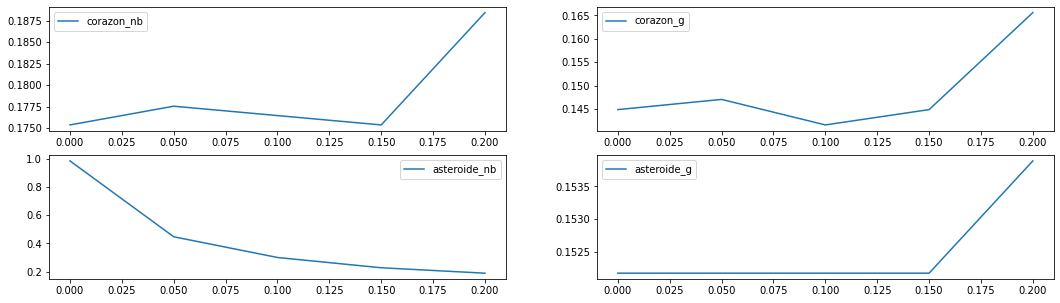

In [ ]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(nrows=2, ncols=2, figsize=(18, 5))
ax[0,0].plot(noiseList, riesgos['corazon_nb'], label='corazon_nb')
ax[0,0].legend()
ax[0,1].plot(noiseList, riesgos['corazon_g'], label='corazon_g')
ax[0,1].legend()
ax[1,0].plot(noiseList, riesgos['asteroide_nb'], label='asteroide_nb')
ax[1,0].legend()
ax[1,1].plot(noiseList, riesgos['asteroide_g'], label='asteroide_g')
ax[1,1].legend()
